In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os

In [2]:
def haar_filter(x,fs):
   # Compute B1 and B2
    B1 = int(0.025 * fs)  # 9 for fs = 360
    B2 = int(0.06 * fs)   # 21 for fs = 360

    # Define c to ensure sum of h(n) = 0
    c = 2 * (B2 - B1) / (2 * B1 + 1)

    # Define the range of h(n)
    n = np.arange(-B2, B2 + 1)

    # Define h(n) based on the conditions
    h = np.zeros_like(n, dtype=float)
    h[np.abs(n) <= B1] = c
    h[(np.abs(n) > B1) & (np.abs(n) <= B2)] = -1

    return signal.convolve(x,h,mode='same')

    #this also works, however even slower
    y1 = np.zeros(len(x))
    y2= np.zeros(len(x))
    y = np.zeros(len(x))
    tmp= np.zeros(B2)
    x_padded = np.concatenate((tmp,x,tmp))
    #go through samples

    tmp = np.zeros(2*(B1+B2))
    tmp[:B2] = c
    tmp[B2:B1+B2] = -1

    for i in range(len(y)):
        #plus B2 in x[] is because of padding
        y1[i] = (c+1)*(x_padded[i+B1 + B2] - x_padded[i-B1 +B2]) + y1[i-1]
        y2[i] = -(x_padded[i+B2 + B2] - x_padded[i-B2 + B2] + y2[i-1])
        y[i] = y1[i] + y2[i]
        #y[i] = -sum(x_padded[i-B1+B2:i+B1+B2+1]) + (c+1) * sum(x_padded[i-B2+B2:i+B2+B2+1])
    return y

In [3]:
def get_candidates(y,x_bsl, fs, c1 = 0.55):
    x2 = np.zeros(len(x_bsl))
    #fill x2 by the formula from paper
    x2[1:len(x_bsl)-1] = np.array( [2 * x_bsl[n] - x_bsl[n+1] - x_bsl[n-1] for n in range(1, len(x_bsl)-1)] )
    
    #calculate s
    s = np.array([y[n]*(x_bsl[n] + c1*x2[n]) for n in range(len(y))])
    
    #tmp just to find the correct range of checking
    tmp = int(0.2*fs)
    
    #find candidates
    candidates =[]
    for k in range(tmp, len(s)-tmp):
        for n in range(-tmp, tmp):
            if np.abs(s[k]) < np.abs(s[k+n]):
                break
            elif n == tmp-1:
                candidates.append(k)

    return candidates, s

In [175]:
#improvements - calculating mean time between heart beats - if heart beat to close - cancel it and take the higher one 


def detect_beats(s,x_bsl,candidates, fs, T=0.1, beta1=0.5, beta2=0.5, taus=[0.08,  0.12, 0.2, 0.25, 0.35], omega_treshold = 0.1):
    #current s in the window
    s_current = []
    #window size
    seconds_window = 10
    samples_window = fs*seconds_window
    #recent detected number
    recent_detected_num = 5
    #detected beats
    detected = []

    #IMPROVEMENT TAKE CHECK MEAN TIME BETWEEN HEART BEATS
    #for start take 0.5 seconds - 120 beats per minute
    mean_time_secs = 0.5
    mean_time_samples_start = mean_time_secs*fs
    mean_time_samples = mean_time_samples_start


    #for every candidate
    for i in candidates:
        s_current = []
        for j in range(i-samples_window, i):
            #skip if out of range
            if j < 0:
                continue
            s_current.append(abs(s[j]))

        #calculate W1, get 5th largest value in the last 10 seconds
        W1 = T
        if len(s_current) >= 5:
            W1 = sorted(s_current)[-5] +T

            
        #calculate W2
        W2 = beta1
        det_len = len(detected)
        #only if there is at least 5 detected beat 
        if det_len > 5:
            recent_det = detected[det_len - recent_detected_num: det_len]

            mew = np.mean([recent_det[i] - recent_det[i+1] for i in range(3)])



            if recent_det[4] - recent_det[3] < 0.7*mew and det_len > 6:
                tmp = recent_det
                recent_det = [detected[-6]]
                recent_det.extend(tmp)
                recent_det = recent_det[:5]

                Ie = sum([taus[i] * (recent_det[i] - recent_det[i+1]) for i in range(4)])
                W2 = beta1 + beta2 * abs((i - recent_det[4])/(2*Ie) - round((i - recent_det[4])/(2*Ie)))
                print(W2)
        
            else:
                Ie = sum([taus[i] * (recent_det[i] - recent_det[i+1]) for i in range(4)])
                W2 = beta1 + beta2 * abs((i - recent_det[4])/Ie - round((i - recent_det[4])/Ie))
            
        
        treshold = W1*W2

        #variation ratio
        omega = 1/2

        if i - int(0.1*fs) > 0:
            tmp_list=  [x_bsl[j] for j in range(i - int(0.1*fs), i + int(0.1*fs))]
            u1 = max(tmp_list) - min(tmp_list)
            u2 = sum([abs(x_bsl[j] - x_bsl[j-1]) for j in range(i - int(0.1*fs)+1, i + int(0.1*fs) +1)])
            omega = u1/u2

        

      
        if abs(s[i]) > treshold:  

            if len(detected)>=2:
                samples_between = detected[-1] - detected[-2]
                #calculate new mean
                mean_time_samples = mean_time_samples * (len(detected)-1)/len(detected) + samples_between/len(detected)
                #so that it doesn't go out of control
                mean_time_samples = min([mean_time_samples_start, mean_time_samples])



            #IMPROVEMENT
            #if next beat is way to close to the first one - don't append it
            if omega > omega_treshold:
                if len(detected) < 1:
                    detected.append(i)
                elif (i - detected[-1]) > 0.7*mean_time_samples:
                    detected.append(i)
                    
                # if too close take the one with the larger s
                else:
                 
                    if s[i] > detected[-1]:
           
                        detected[-1] = i




    return detected


In [18]:
def evaluate_results(annotation_beats, detected_beats,fs):
    time_tolerance = 0.15/2
    tolerance = round(time_tolerance*fs)

    not_detected = []
    for i in annotation_beats:
        for j in range(i-tolerance, i+tolerance+1):
            if j in detected_beats:
                break
        if j == i+tolerance:
            not_detected.append(i)
            #print(i)


    falsely_detected = []
    for i in detected_beats:
        for j in range(i-tolerance, i+tolerance+1):
            if j in annotation_beats:
                break
        if j == i+tolerance:
            falsely_detected.append(i)
            
    #print('Not detected:', len(not_detected))
    #print('Falsely detected:', len(falsely_detected))

    SE = (len(detected_beats) - len(falsely_detected))/(len(annotation_beats)+10e-8)
    PP = (len(detected_beats) - len(falsely_detected))/(len(detected_beats) +10e-8)
    print('Sensitivity:', SE)
    print('Positive predictivity:', PP)
    print("not det " + str(not_detected))
    print("false detected " + str(falsely_detected))
    
    return SE,PP, not_detected, falsely_detected

In [6]:
def eval_one_rec(database, record_num,T=0.1, beta2=0.1, beta1=0.1, taus=[0.08,  0.12, 0.2, 0.25, 0.35], omega_treshold = 0.1):
    #get only number of file
    record_num = str(record_num)
    sig = wfdb.rdsamp(database+ "/" + record_num)
    x_both = sig[0][:].flatten()
    x = x_both[0::2]

    #read sampling frequency
    fs = wfdb.rdsamp(database + "/"+ record_num)[1]['fs']
    #read annotation file
    record_name = database+ "/" + record_num
    annotation = wfdb.rdann(record_name, 'atr')
    beat_peaks = annotation.sample[:]
    #get rid of baseline
    butter_filter = signal.butter(5, 2, 'high', fs=fs, output='sos')
    x_bsl = signal.sosfilt(butter_filter, x)
    x_bsl[::-1] = signal.sosfilt(butter_filter, x_bsl[::-1])

    #delay
    delay = 1
    x_bsl[:-delay] = x_bsl[delay:]

    #apply haar filter
    y = haar_filter(x_bsl,fs)

    #get candidates
    candidates,s = get_candidates(y,x_bsl,fs)

    #detect beats
    detected = detect_beats(s,x_bsl,candidates, fs, T=T, beta2=beta2, beta1=beta1)

    #eval results
    print(record_num)
    SE,PP, not_detected, falsely_detected = evaluate_results(beat_peaks, detected,fs)
    
    return SE,PP, not_detected, falsely_detected, len(beat_peaks)

In [7]:
def eval_on_db(database, T=0.1, beta2=0.1, beta1=0.1, num_recordings=200):
    lst_SE_PP_lenOfSig = []

    files = [f for f in os.listdir(database) if os.path.isfile(os.path.join(database, f))]

    target_ext = ".hea"

    for file in files:
        if target_ext in file:
            record_num = file.split(".")[0]
            SE,PP, not_detected, falsely_detected, L = eval_one_rec(database,record_num, T=T, beta1=beta1, beta2=beta2)
            lst_SE_PP_lenOfSig.append([SE,PP,L])

            if len(lst_SE_PP_lenOfSig) > num_recordings:
                break

        else:
            continue

    mean_SE = np.mean([el[0] for el in lst_SE_PP_lenOfSig])
    mean_PP = np.mean([el[1] for el in lst_SE_PP_lenOfSig])
    whole_len = sum([el[2] for el in lst_SE_PP_lenOfSig])
    mean_SE_account_for_len = sum([el[0] * el[2]/whole_len for el in lst_SE_PP_lenOfSig])
    mean_PP_account_for_len = sum([el[1] * el[2]/whole_len for el in lst_SE_PP_lenOfSig])
    print("for beta1 = " + str(beta1) + ", beta2 = " + str(beta2) + ", T = " + str(T))
    print("mean SE: " + str(mean_SE))
    print("mean PP: " + str(mean_PP))
    print("SE accounting for length: " + str(mean_SE_account_for_len))
    print("PP accounting for length: " + str(mean_PP_account_for_len))

TRYING OUT ON ONE SIGNAL

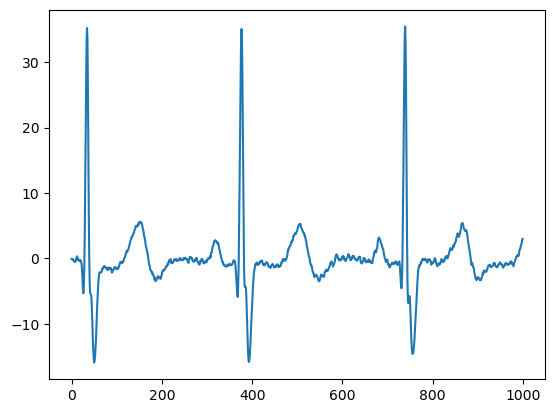

In [ ]:
#read signal
database = "mit-bih-data"
record_num = "231"
sig = wfdb.rdsamp(database+ "/" + record_num)
x_both = sig[0][:].flatten()
x = x_both[0::2]

#read sampling frequency
fs = wfdb.rdsamp(database + "/"+ record_num)[1]['fs']
#read annotation file
record_name = database+ "/" + record_num
annotation = wfdb.rdann(record_name, 'atr')
beat_peaks = annotation.sample[:]
#get rid of baseline
butter_filter = signal.butter(5, 2, 'high', fs=fs, output='sos')
x_bsl = signal.sosfilt(butter_filter, x)
x_bsl[::-1] = signal.sosfilt(butter_filter, x_bsl[::-1])

#delay
delay = 1 ()
x_bsl[:-delay] = x_bsl[delay:]

#apply haar filter
y = haar_filter(x_bsl,fs)

start_int =5000
end_int = start_int + 1000
plt.plot(x_bsl[start_int:end_int]*20)
#plt.plot(y[start_int:end_int])


In [180]:
candidates,s = get_candidates(y,x_bsl,fs)

In [181]:
detected = detect_beats(s,x_bsl,candidates, fs, T=1, beta2=0.01, beta1=0.1)

In [182]:
res = evaluate_results(beat_peaks, detected, fs)

Sensitivity: 0.7812033813634409
Positive predictivity: 0.9999999999363463
not det [57, 2083, 34275, 35142, 35220, 35853, 36474, 37090, 37713, 38298, 38919, 39509, 40096, 40707, 41291, 41892, 42444, 43024, 43597, 44177, 44767, 45342, 45926, 46490, 47050, 47658, 48249, 48834, 49431, 50031, 50616, 51207, 51802, 52315, 53176, 53625, 119218, 120082, 120168, 120788, 121420, 122041, 122660, 123280, 123879, 124458, 125038, 125638, 126223, 126811, 127410, 128007, 128597, 129192, 129794, 130393, 130990, 131559, 132166, 132737, 133348, 133965, 134588, 135227, 135844, 136445, 137036, 137608, 138209, 138788, 139384, 139981, 140564, 141164, 141743, 142312, 142879, 143442, 144033, 144624, 145216, 145798, 146390, 146971, 147577, 148192, 148799, 149398, 149994, 150578, 151166, 151768, 152376, 152976, 153584, 154182, 154785, 155375, 155957, 156527, 157120, 157704, 158288, 158868, 159436, 160022, 160612, 161198, 161788, 162360, 162953, 163537, 164141, 164737, 165355, 165977, 166582, 167203, 167797, 16842

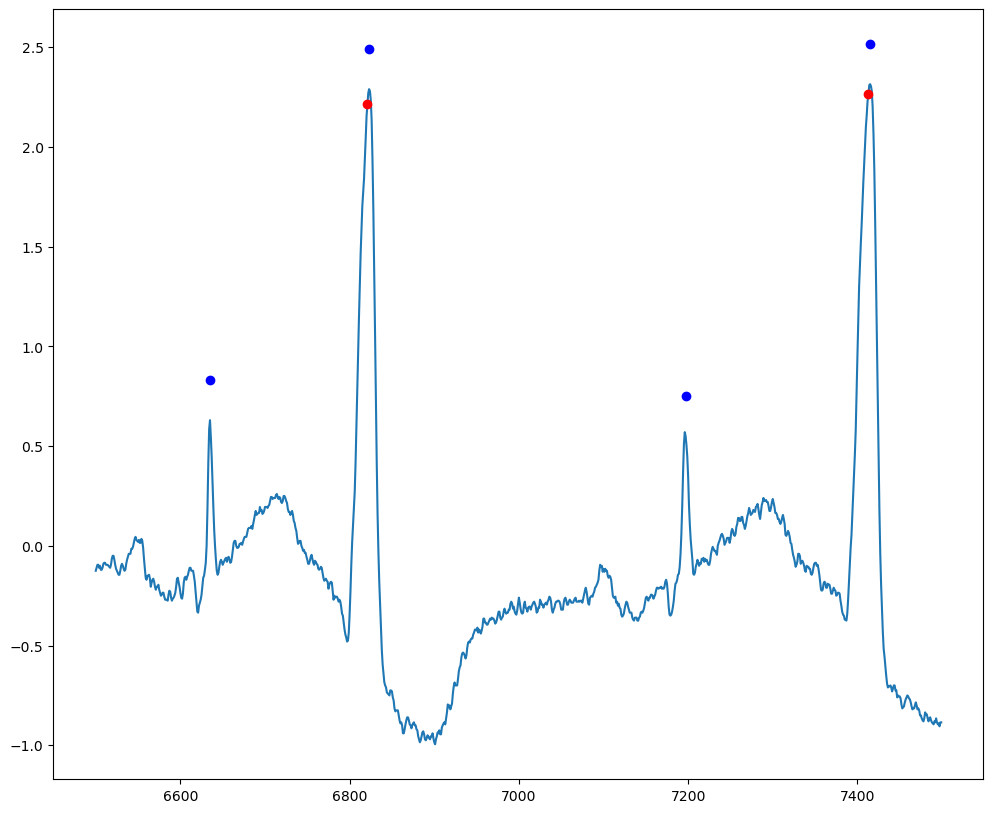

In [139]:
start_int =7000 - 500
end_int = start_int + 1000
plt.figure(figsize=(12,10))
plt.plot(range(start_int, end_int), x[start_int:end_int])
detected_interval = [n for n in detected if n > start_int and n < end_int]
plt.plot(detected_interval, [x[n] for n in detected_interval], 'ro')
beat_peaks_interval = [n for n in beat_peaks if n > start_int and n < end_int]
plt.plot(beat_peaks_interval, [x[n] + 0.2 for n in beat_peaks_interval], 'bo')

GRID SEARCH

In [ ]:
#grid search
for T in [1]:
    for beta2 in [0.01,0.1,1]:
        for beta1 in [0.01,0.1,1]:
            if T==1 and beta2 == 0.01 and beta1 == 0.01:
                continue
            if T==1 and beta2 == 0.01 and beta1 == 0.1:
                continue
            eval_on_db("mit-bih-data", T=T, beta2=beta2, beta1=beta1)

for beta1 = 1, beta2 = 0.01, T = 1
mean SE: 0.11567677048547953
mean PP: 0.9985224071909693
SE accounting for length: 0.11194261719748191
PP accounting for length: 0.9983981464175923
for beta1 = 0.01, beta2 = 0.1, T = 1
mean SE: 0.9729947938125254
mean PP: 0.9080163839218881
SE accounting for length: 0.972773353887184
PP accounting for length: 0.9195421754582892
for beta1 = 0.1, beta2 = 0.1, T = 1
mean SE: 0.9567584361817526
mean PP: 0.9774290997409295
SE accounting for length: 0.9562438413398276
PP accounting for length: 0.982024609193744
for beta1 = 1, beta2 = 0.1, T = 1
mean SE: 0.08282131313759543
mean PP: 0.9982364394794595
SE accounting for length: 0.08029508109050805
PP accounting for length: 0.998050802070628
for beta1 = 0.01, beta2 = 1, T = 1
mean SE: 0.918257454998212
mean PP: 0.9913427447926916
SE accounting for length: 0.9140500856267132
PP accounting for length: 0.9923344333374067
for beta1 = 0.1, beta2 = 1, T = 1
mean SE: 0.8863341557921074
mean PP: 0.9964625614593391
SE 

In [9]:
#best parameters found out from the grid search
beta1 = 0.1
beta2 = 0.01
T = 1
eval_on_db("mit-bih-data", T=T, beta2=beta2, beta1=beta1)

100
Sensitivity: 0.9991204924802498
Positive predictivity: 0.999999999955986
101
Sensitivity: 0.9957310565103665
Positive predictivity: 0.9983948635099842
102
Sensitivity: 0.9922445255021787
Positive predictivity: 0.9945130315045948
103
Sensitivity: 0.9961740793402117
Positive predictivity: 0.9999999999519924
104
Sensitivity: 0.950237992170046
Positive predictivity: 0.9829901521493738
105
Sensitivity: 0.9502043849516832
Positive predictivity: 0.9729832571928089
106
Sensitivity: 0.9628217349398084
Positive predictivity: 0.9782082323981498
107
Sensitivity: 0.9892523364023714
Positive predictivity: 0.9810009267386006
108
Sensitivity: 0.9643640350348485
Positive predictivity: 0.9396367520865578
109
Sensitivity: 0.9984220906903976
Positive predictivity: 0.9999999999604899
111
Sensitivity: 0.9929676511489467
Positive predictivity: 0.9359257622211258
112
Sensitivity: 0.9956862744707574
Positive predictivity: 0.9984270546205889
113
Sensitivity: 0.9988864141982802
Positive predictivity: 0.50893

In [124]:
#evaluating wih best parameteres with improved alghoritm
beta1 = 0.1
beta2 = 0.01
T = 1
eval_on_db("mit-bih-data", T=T, beta2=beta2, beta1=beta1)

100
Sensitivity: 0.9991204924802498
Positive predictivity: 0.999999999955986
not det [18, 649991]
false detected []
101
Sensitivity: 0.9946638206512985
Positive predictivity: 0.9989281885852664
not det [7, 40603, 40884, 41930, 63096, 63414, 115124, 115478, 308294]
false detected [115312, 308250]
102
Sensitivity: 0.9922445255021787
Positive predictivity: 0.9945130315045948
not det [68, 29133, 34216, 38682, 62969, 354044, 356125, 371886, 414789, 443355, 450830, 457973, 505325, 528456, 544544, 584655, 645411]
false detected [354012, 356093, 371854, 414758, 443322, 450794, 457941, 505290, 528425, 544513, 584621, 645378]
103
Sensitivity: 0.9961740793402117
Positive predictivity: 0.9999999999519924
not det [21, 392322, 394327, 395437, 413367, 468219, 478385, 594882]
false detected []
104
Sensitivity: 0.9485071397252919
Positive predictivity: 0.9829596412115266
not det [36, 73, 901, 2062, 2361, 4995, 7556, 8765, 9378, 10232, 10533, 15233, 16390, 17571, 17869, 18724, 19318, 19616, 19910, 21056

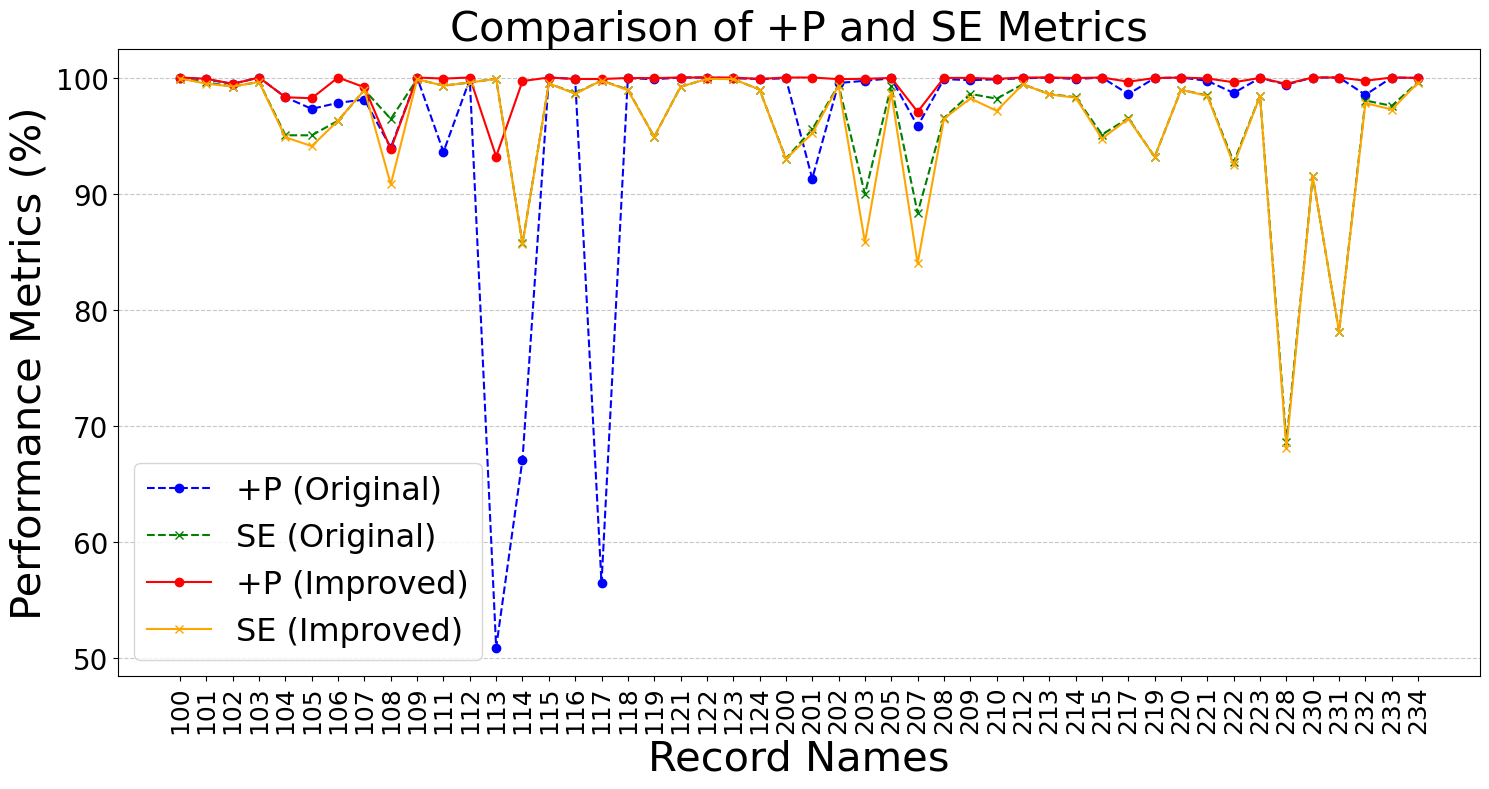

In [235]:
#making graphs for report 
with open("RESULTS_BEST_PARAMS.txt") as file:
    lines_results = file.readlines()

with open("RESULTS_BEST_PARAMS_IMPROVED.txt") as file:
    lines_results_improved = file.readlines()

record_names =  lines_results[:143:3]
record_names = [el.strip() for el in record_names]

PP = lines_results[2:145:3]
PP = [float(el.split(":")[1].strip())*100 for el in PP]
SE = lines_results[1:145:3]
SE = [float(el.split(":")[1].strip())*100 for el in SE]

PP_improved = lines_results_improved[2:240:5]
PP_improved = [float(el.split(":")[1].strip())*100 for el in PP_improved]
SE_improved = lines_results_improved[1:240:5]
SE_improved = [float(el.split(":")[1].strip())*100 for el in SE_improved]

# Generate x-axis positions
x_positions = np.arange(len(record_names))

# Create the plot
plt.figure(figsize=(15, 8))

# Original results
plt.plot(x_positions, PP, label="+P (Original)", marker="o", linestyle="--", color="blue")
plt.plot(x_positions, SE, label="SE (Original)", marker="x", linestyle="--", color="green")

# Improved results
plt.plot(x_positions, PP_improved, label="+P (Improved)", marker="o", linestyle="-", color="red")
plt.plot(x_positions, SE_improved, label="SE (Improved)", marker="x", linestyle="-", color="orange")

# Add labels and title
plt.xticks(ticks=x_positions, labels=record_names, rotation=90, fontsize=18)
plt.xlabel("Record Names", fontsize=30)
plt.yticks(fontsize=20)
plt.ylabel("Performance Metrics (%)", fontsize=30)
plt.title("Comparison of +P and SE Metrics", fontsize=30)

# Add grid, legend, and tight layout
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=23, loc = "lower left")
plt.tight_layout()

plt.savefig('plot.pdf')

# Show the plot
plt.show()

